In [95]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


In [96]:
# Load dataset
df = pd.read_csv("sample_data/adult.csv")
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [97]:
# Quick preview
df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})

# Quick preview
df.tail()


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
30157,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0
30158,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
30159,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
30160,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
30161,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [98]:
# Fill with most common values
df['occupation'].fillna('Prof-specialty')
df['workclass'].fillna('Private')
df['native.country'].fillna('United-States')

# Check again
df.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
education.num,0
marital.status,0
occupation,0
relationship,0
race,0
sex,0


In [99]:
df.drop(['fnlwgt'], axis=1, inplace=True)

# Group low education levels into "School"
df['education'] = df['education'].replace(
    ['11th','9th','7th-8th','5th-6th','10th','1st-4th','Preschool','12th'],
    'School'
)

# Combine minority races
df['race'] = df['race'].replace(['Black','Asian-Pac-Islander','Amer-Indian-Eskimo','Other'], 'Other')

# Combine countries into 'Other' except 'United-States'
df['native.country'] = df['native.country'].apply(lambda x: x if x == 'United-States' else 'Other')


In [100]:
dataset=df.copy()

In [101]:
def categorize_hours(h):
    if h <= 30:
        return 'Lesser Hours'
    elif h <= 40:
        return 'Normal Hours'
    else:
        return 'Extra Hours'

dataset['Hours per Week'] = dataset['hours.per.week'].apply(categorize_hours)


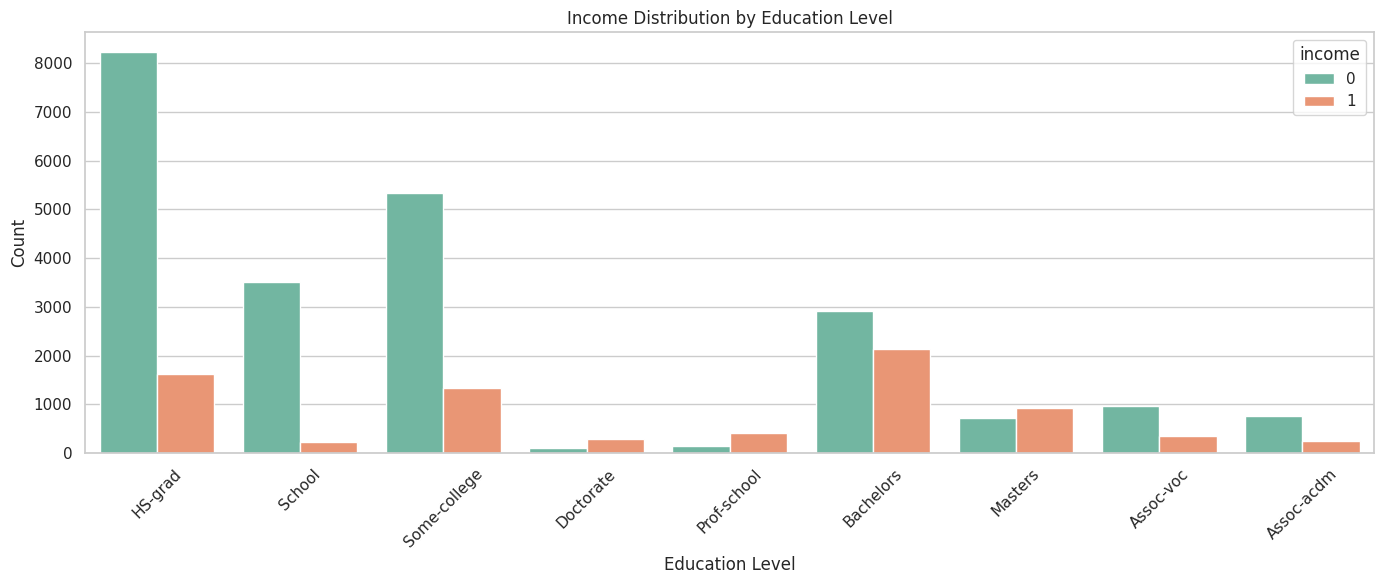

In [102]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))  # Wider plot for all education labels

sns.countplot(x='education', hue='income', data=dataset, palette='Set2')

plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.title('Income Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



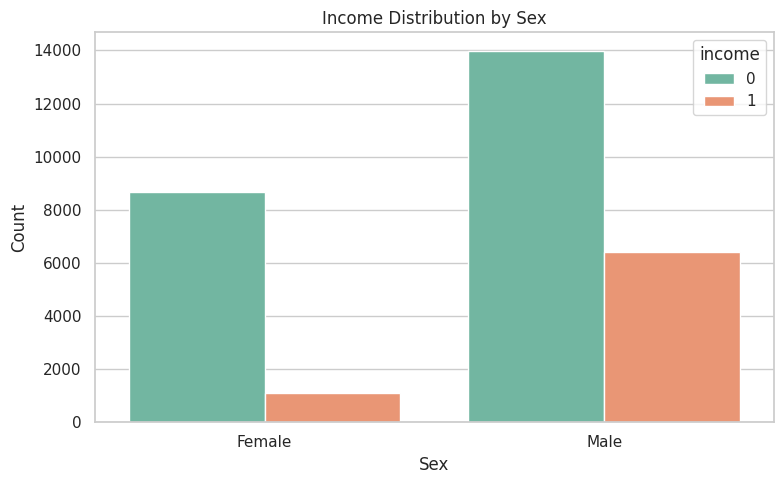

In [103]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))  # Adjust figure size as needed

# Swapping x and hue for better spacing
sns.countplot(x='sex', hue='income', data=dataset, palette='Set2')

plt.title('Income Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

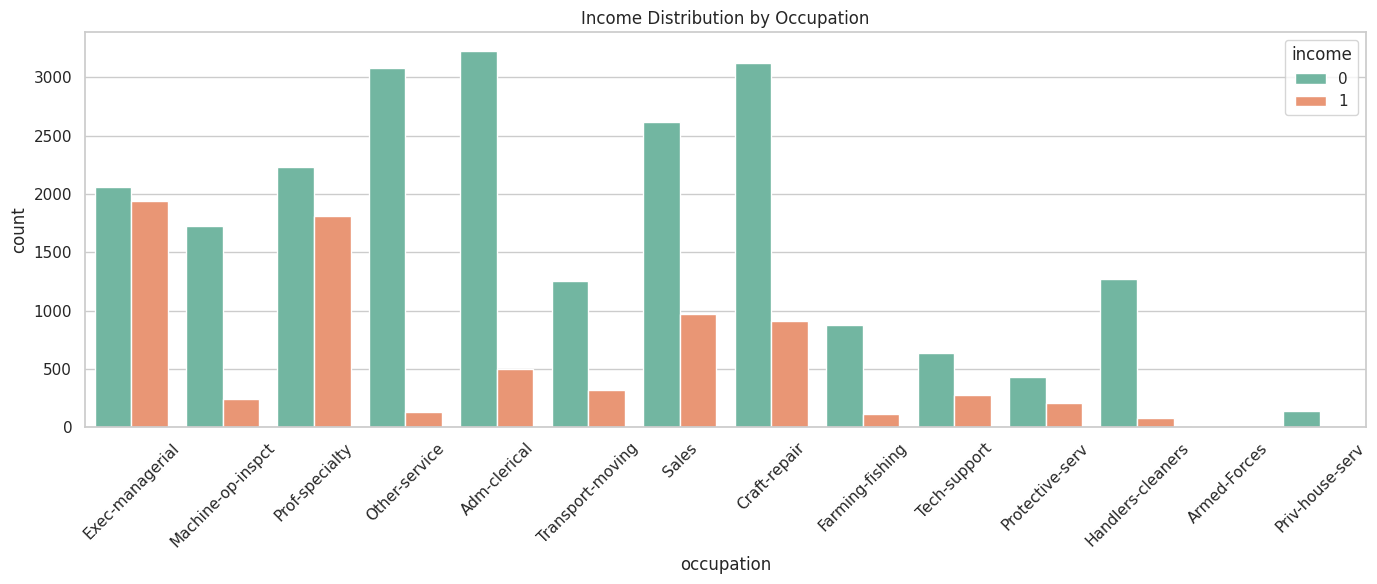

In [104]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))  # Wider figure
sns.countplot(x='occupation', hue='income', data=dataset, palette='Set2')
plt.xticks(rotation=45)
plt.title('Income Distribution by Occupation')
plt.tight_layout()
plt.show()


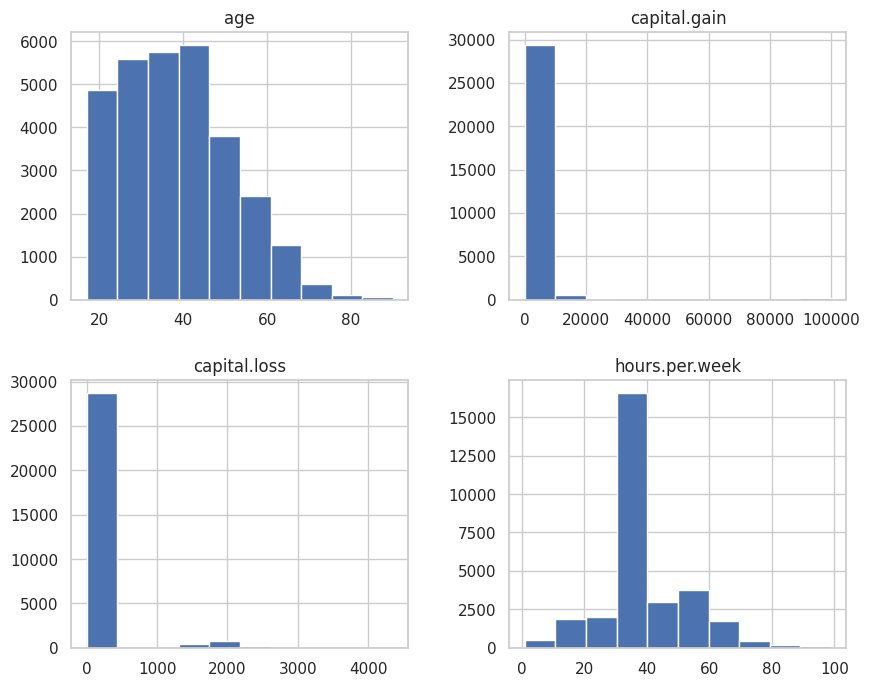

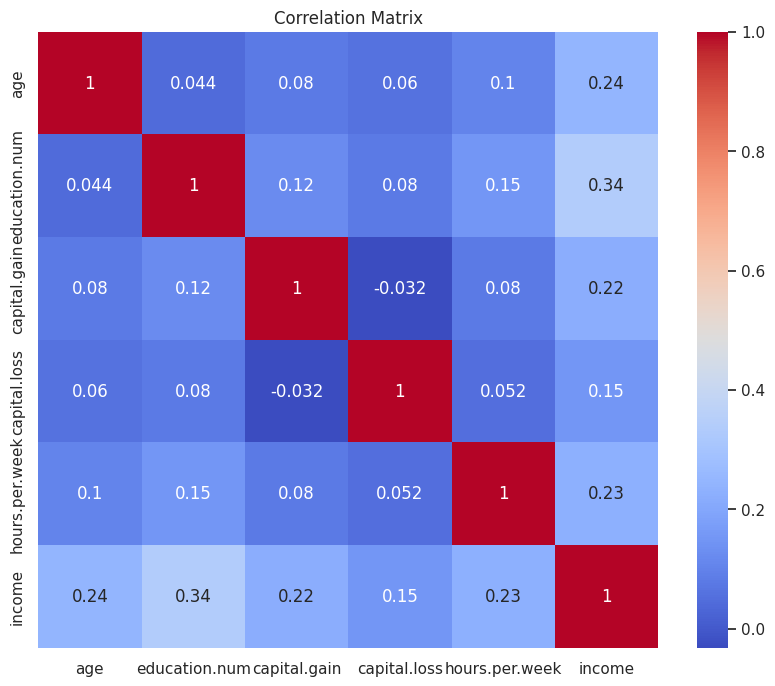

In [105]:
# Plotting numeric distributions
df[['age', 'capital.gain', 'capital.loss', 'hours.per.week']].hist(figsize=(10, 8))

# Correlation heatmap
corr = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [106]:
# Encode categorical columns
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Define features and target
X = df.drop('income', axis=1)
y = df['income']
expected_columns = X.columns.tolist()

In [107]:
X.head()

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,82,2,4,9,6,3,1,1,0,0,4356,18,1
1,54,2,7,4,0,6,4,1,0,0,3900,40,1
2,41,2,8,10,5,9,3,1,0,0,3900,40,1
3,34,2,4,9,0,7,4,1,0,0,3770,45,1
4,38,2,7,6,5,0,4,1,1,0,3770,40,1


In [108]:
# Split data into test data and training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [110]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Naive Bayes': GaussianNB(),
    'Support Vector Machine': LinearSVC(max_iter=5000),
    'Decision Tree': DecisionTreeClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
    test_acc = accuracy_score(y_test, model.predict(X_test_scaled))
    results[name] = {'Train Accuracy': round(train_acc * 100, 2), 'Test Accuracy': round(test_acc * 100, 2)}

In [111]:
# View results
result_df = pd.DataFrame(results).T.sort_values(by='Test Accuracy', ascending=False)
print("Model Performance:\n", result_df)

Model Performance:
                         Train Accuracy  Test Accuracy
Random Forest                    97.78          84.34
Logistic Regression              82.13          81.80
Support Vector Machine           82.02          81.75
Decision Tree                    97.78          80.71
K-Nearest Neighbors              89.64          80.36
Naive Bayes                      80.01          79.07


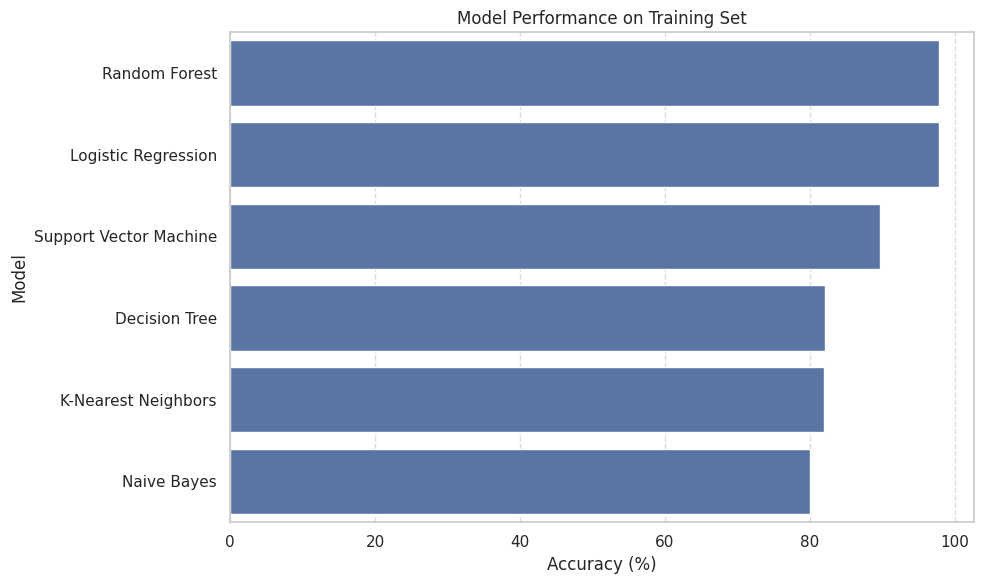

In [112]:
# Visualize Training Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x="Train Accuracy", y=result_df.index, data=result_df.sort_values(by="Train Accuracy", ascending=False))
plt.title("Model Performance on Training Set")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [113]:
# Choose and save the best model
best_model = models['Random Forest']
joblib.dump(best_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(expected_columns, 'expected_columns.pkl')

print("\n✅ Model and other components saved.")


✅ Model and other components saved.


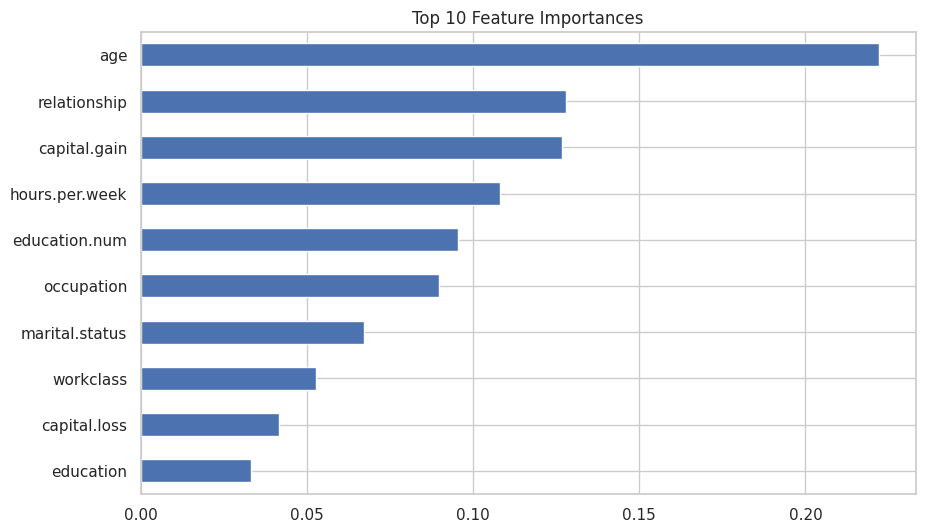

In [114]:
importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# Top 10 important features
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [115]:
low_impact = ['sex', 'race', 'native.country']
df.drop(columns=low_impact, inplace=True)


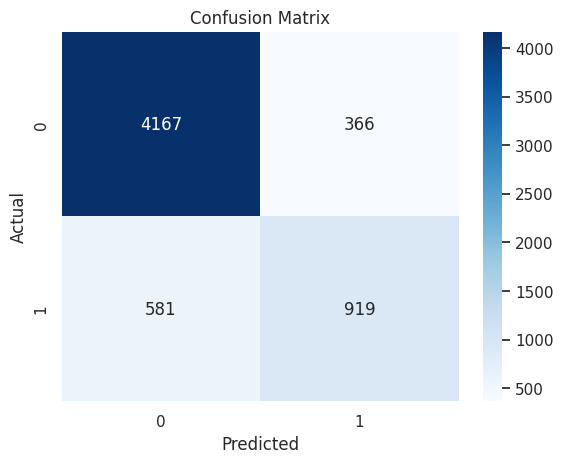

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4533
           1       0.72      0.61      0.66      1500

    accuracy                           0.84      6033
   macro avg       0.80      0.77      0.78      6033
weighted avg       0.84      0.84      0.84      6033



In [116]:
from sklearn.metrics import confusion_matrix, classification_report

# Choose the best performing model
best_model = RandomForestClassifier(n_estimators=100)
best_model.fit(X_train, y_train)

# Predict on test data
Y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, Y_pred))


In [117]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print("Cross-validation scores:", np.round(cv_scores, 2))
print("Mean CV accuracy:", round(cv_scores.mean() * 100, 2), "%")


Cross-validation scores: [0.85 0.85 0.84 0.85 0.84]
Mean CV accuracy: 84.55 %


In [118]:
# Load saved components
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')
label_encoders = joblib.load('label_encoders.pkl')
expected_columns = joblib.load('expected_columns.pkl')

In [119]:
# Sample input for prediction
sample = pd.DataFrame([{
    'age': 37,
    'workclass': 'Private',
    'fnlwgt': 284582,
    'education': 'Bachelors',
    'marital.status': 'Married-civ-spouse',
    'occupation': 'Prof-specialty',
    'relationship': 'Husband',
    'race': 'White',
    'sex': 'Male',
    'hours.per.week': 45,
    'native.country': 'United-States',
    'capital.gain': 0,
    'capital.loss': 0,
    'education.num': 13
}])

# Encode sample
for col in sample.columns:
    if col in label_encoders:
        sample[col] = label_encoders[col].transform(sample[col])

# Ensure correct column order
sample = sample[expected_columns]

In [120]:
# Scale and predict
sample_scaled = scaler.transform(sample)
prediction = model.predict(sample_scaled)

print("\nPredicted Income:", ">50K" if prediction[0] == 1 else "<=50K")


Predicted Income: >50K
